# Task 3: Correlation Between News and Stock Movement

Load Data

In [1]:
# 1. Import necessary libraries
import os
import pandas as pd

# 2. Path to your stock data folder
DATA_FOLDER = "../data/stock_data"

# 3. Read all CSVs inside the folder
csv_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith(".csv")]
print("CSV files found:", csv_files)

# 4. Load all CSVs into a dictionary of DataFrames
dfs_stocks = {}
for file in csv_files:
    file_path = os.path.join(DATA_FOLDER, file)
    dfs_stocks[file] = pd.read_csv(file_path, parse_dates=['Date'])  # make sure Date is datetime

# 5. Example: check loaded data
for name, df in dfs_stocks.items():
    print(f"{name}: {df.shape} rows, columns: {df.columns.tolist()}")
# Load news
df_news = pd.read_csv("../data/raw_analyst_ratings.csv", parse_dates=['date'])


CSV files found: ['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv']
AAPL.csv: (3774, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
AMZN.csv: (3774, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
GOOG.csv: (3774, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
META.csv: (2923, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
MSFT.csv: (3774, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
NVDA.csv: (3774, 6) rows, columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


Normalize Dates

In [5]:
# ================================
# Prepare and Align Data
# ================================

import pandas as pd

# 1. Normalize news dates
df_news.columns = df_news.columns.str.strip()  # remove extra spaces
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')  # convert to datetime
df_news = df_news.dropna(subset=['date'])  # drop invalid dates
df_news['date'] = df_news['date'].dt.date  # keep only date part

print("News data prepared:")
print(df_news.head())

# 2. Prepare stock DataFrames: keep only Date and Close for simplicity
dfs_close = {}
for stock_name, df in dfs_stocks.items():
    df = df.copy()
    df.columns = df.columns.str.strip()  # remove spaces
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df['Date'] = df['Date'].dt.date  # keep only date part
    df = df.sort_values('Date')
    
    # Keep only Date and Close columns
    dfs_close[stock_name] = df[['Date', 'Close']]

# 3. Merge daily news sentiment later: for now we have clean Close prices
for stock_name, df in dfs_close.items():
    print(f"{stock_name}: {df.shape} rows")


News data prepared:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  
3  2020-05-22     A  
4  2020-05

Sentiment Analysis + Daily Returns

In [6]:

from textblob import TextBlob

# 1. Sentiment analysis on news headlines
df_news['sentiment'] = df_news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
# Polarity ranges from -1 (negative) to +1 (positive)

# 2. Aggregate daily sentiment scores (average if multiple news on same day)
df_daily_sentiment = df_news.groupby('date')['sentiment'].mean().reset_index()
df_daily_sentiment.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)
print("Daily news sentiment:")
print(df_daily_sentiment.head())

# 3. Calculate daily stock returns for each stock
dfs_returns = {}
for stock_name, df in dfs_close.items():
    df = df.copy()
    df['daily_return'] = df['Close'].pct_change()  # percentage change
    dfs_returns[stock_name] = df
    print(f"{stock_name} daily returns calculated")

# 4. Merge daily sentiment with stock returns
dfs_merged = {}
for stock_name, df in dfs_returns.items():
    df_merged = pd.merge(df, df_daily_sentiment, how='left', left_on='Date', right_on='date')
    df_merged.drop(columns=['date'], inplace=True)
    dfs_merged[stock_name] = df_merged
    print(f"{stock_name} merged with daily sentiment")


Daily news sentiment:
         date  avg_sentiment
0  2011-04-27       0.000000
1  2011-04-28       0.068182
2  2011-04-29       0.166667
3  2011-04-30       0.500000
4  2011-05-01       0.000000
AAPL.csv daily returns calculated
AMZN.csv daily returns calculated
GOOG.csv daily returns calculated
META.csv daily returns calculated
MSFT.csv daily returns calculated
NVDA.csv daily returns calculated
AAPL.csv merged with daily sentiment
AMZN.csv merged with daily sentiment
GOOG.csv merged with daily sentiment
META.csv merged with daily sentiment
MSFT.csv merged with daily sentiment
NVDA.csv merged with daily sentiment


# Correlation Analysis between News Sentiment and Stock Returns

Compute daily stock returns

In [7]:
# Compute daily returns for all stocks
dfs_returns = {}
for stock_name, df in dfs_stocks.items():
    df_sorted = df.sort_values('Date').copy()
    df_sorted['Daily_Return'] = df_sorted['Close'].pct_change()  # percentage change
    dfs_returns[stock_name] = df_sorted[['Date', 'Daily_Return']]


Aggregate daily news sentiment

In [9]:
from textblob import TextBlob

# Example: create sentiment_score column
df_news['sentiment_score'] = df_news['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Check
print(df_news[['headline', 'sentiment_score']].head())


                                            headline  sentiment_score
0            Stocks That Hit 52-Week Highs On Friday              0.0
1         Stocks That Hit 52-Week Highs On Wednesday              0.0
2                      71 Biggest Movers From Friday              0.0
3       46 Stocks Moving In Friday's Mid-Day Session              0.0
4  B of A Securities Maintains Neutral on Agilent...              0.0


In [10]:
daily_sentiment = df_news.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date'}, inplace=True)


Merge stock returns with sentiment

In [12]:
# Ensure 'Date' columns are datetime in all DataFrames

# For sentiment
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# For each stock returns DataFrame
for stock_name, df_stock in dfs_returns.items():
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    dfs_returns[stock_name] = df_stock  # update in the dictionary

# Now merge safely
dfs_corr = {}
for stock_name, df_stock in dfs_returns.items():
    df_corr = pd.merge(df_stock, daily_sentiment, on='Date', how='inner')
    dfs_corr[stock_name] = df_corr

# Check one example
print(dfs_corr['AAPL.csv'].head())


        Date  Daily_Return  sentiment_score
0 2011-04-27     -0.000770         0.000000
1 2011-04-28     -0.009710         0.068182
2 2011-04-29      0.009748         0.166667
3 2011-05-02     -0.010997        -0.009259
4 2011-05-03      0.005545         0.000000


C:\Users\kalki\AppData\Local\Temp\ipykernel_14008\904130814.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stock['Date'] = pd.to_datetime(df_stock['Date'])


In [13]:
# Dictionary to store merged DataFrames for correlation
dfs_corr = {}

for stock_name, df_stock in dfs_returns.items():
    # Merge with daily sentiment
    df_corr = pd.merge(df_stock, daily_sentiment, on='Date', how='inner')
    dfs_corr[stock_name] = df_corr

# Check one example
print(dfs_corr['AAPL.csv'].head())


        Date  Daily_Return  sentiment_score
0 2011-04-27     -0.000770         0.000000
1 2011-04-28     -0.009710         0.068182
2 2011-04-29      0.009748         0.166667
3 2011-05-02     -0.010997        -0.009259
4 2011-05-03      0.005545         0.000000


In [15]:
# Step 1: Calculate daily returns for each stock
dfs_returns = {}
for stock_name, df_stock in dfs_stocks.items():
    df = df_stock.copy()
    df['daily_return'] = df['Close'].pct_change()  # percent change of Close
    df = df.dropna(subset=['daily_return'])  # drop first row with NaN
    dfs_returns[stock_name] = df[['Date', 'daily_return']]  # keep only necessary columns

# Step 2: Make sure Date columns are datetime (if not already)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
for stock_name, df in dfs_returns.items():
    df['Date'] = pd.to_datetime(df['Date'])
    dfs_returns[stock_name] = df

# Step 3: Merge daily returns with sentiment
dfs_corr = {}
for stock_name, df_stock in dfs_returns.items():
    df_corr = pd.merge(df_stock, daily_sentiment, on='Date', how='inner')
    dfs_corr[stock_name] = df_corr

# Step 4: Compute correlation
for stock_name, df in dfs_corr.items():
    correlation = df['daily_return'].corr(df['sentiment_score'])
    print(f"{stock_name} correlation: {correlation:.4f}")


AAPL.csv correlation: -0.0028
AMZN.csv correlation: -0.0194
GOOG.csv correlation: 0.0143
META.csv correlation: -0.0003
MSFT.csv correlation: -0.0118
NVDA.csv correlation: 0.0091


Calculate daily returns for each stock

In [17]:
dfs_returns = {}
for stock_name, df_stock in dfs_stocks.items():
    df = df_stock.copy()
    df['daily_return'] = df['Close'].pct_change()
    df = df.dropna(subset=['daily_return'])
    df['Date'] = pd.to_datetime(df['Date'])
    dfs_returns[stock_name] = df[['Date', 'daily_return']]

Merge daily returns with sentiment

In [18]:
dfs_corr = {}
for stock_name, df_stock in dfs_returns.items():
    df_corr = pd.merge(df_stock, daily_sentiment, on='Date', how='inner')
    dfs_corr[stock_name] = df_corr

Compute and display correlation

In [19]:
for stock_name, df in dfs_corr.items():
    correlation = df['daily_return'].corr(df['sentiment_score'])
    print(f"{stock_name} correlation: {correlation:.4f}")

AAPL.csv correlation: -0.0028
AMZN.csv correlation: -0.0194
GOOG.csv correlation: 0.0143
META.csv correlation: -0.0003
MSFT.csv correlation: -0.0118
NVDA.csv correlation: 0.0091


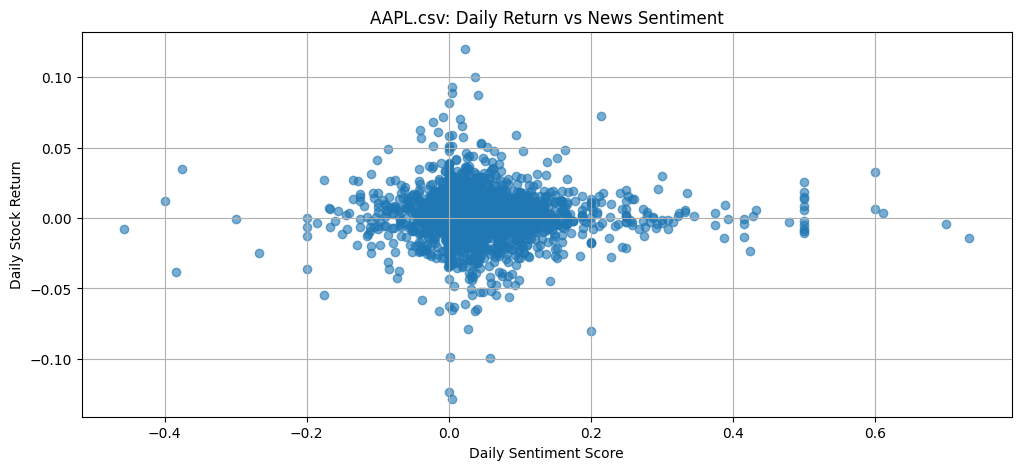

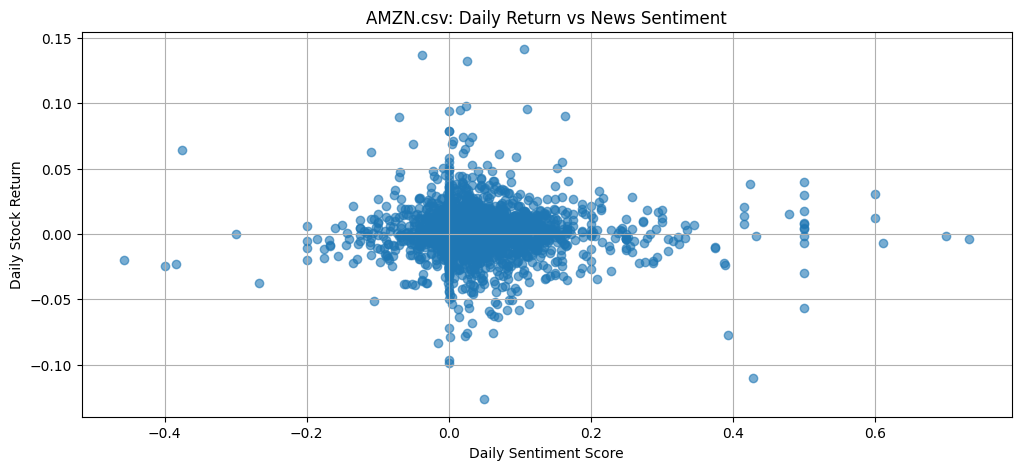

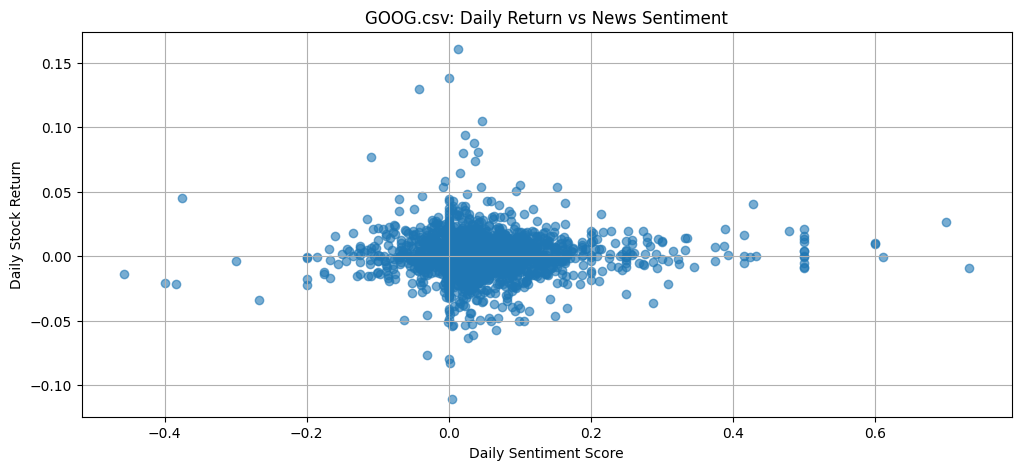

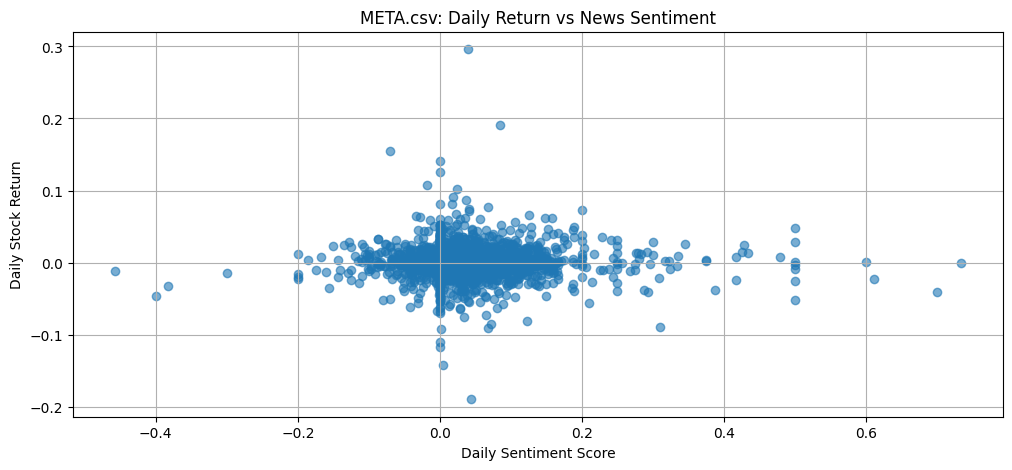

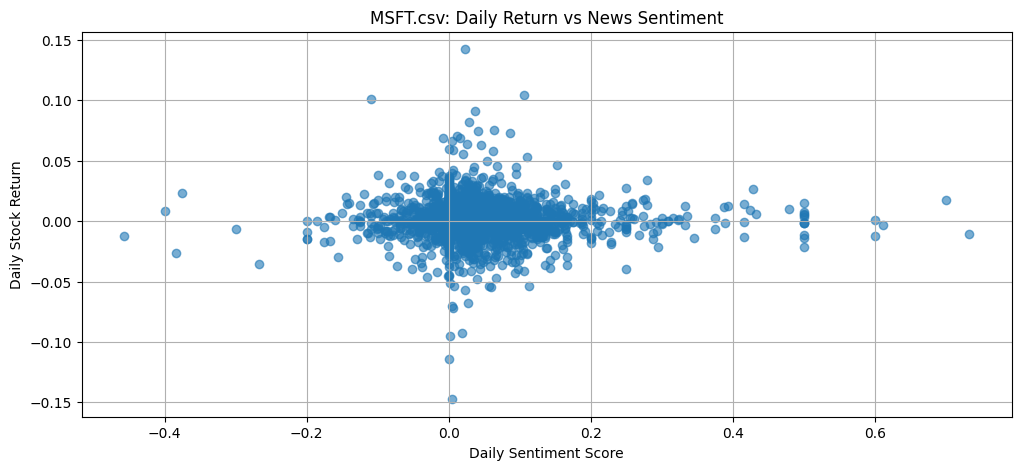

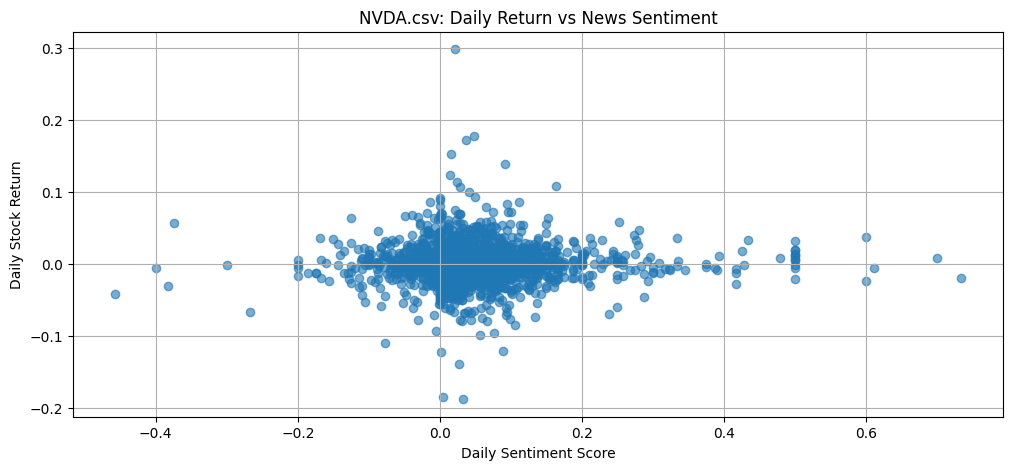

In [20]:
import matplotlib.pyplot as plt

# Plot daily returns vs sentiment for all stocks
for stock_name, df in dfs_corr.items():
    plt.figure(figsize=(12,5))
    plt.scatter(df['sentiment_score'], df['daily_return'], alpha=0.6)
    plt.title(f"{stock_name}: Daily Return vs News Sentiment")
    plt.xlabel("Daily Sentiment Score")
    plt.ylabel("Daily Stock Return")
    plt.grid(True)
    plt.show()


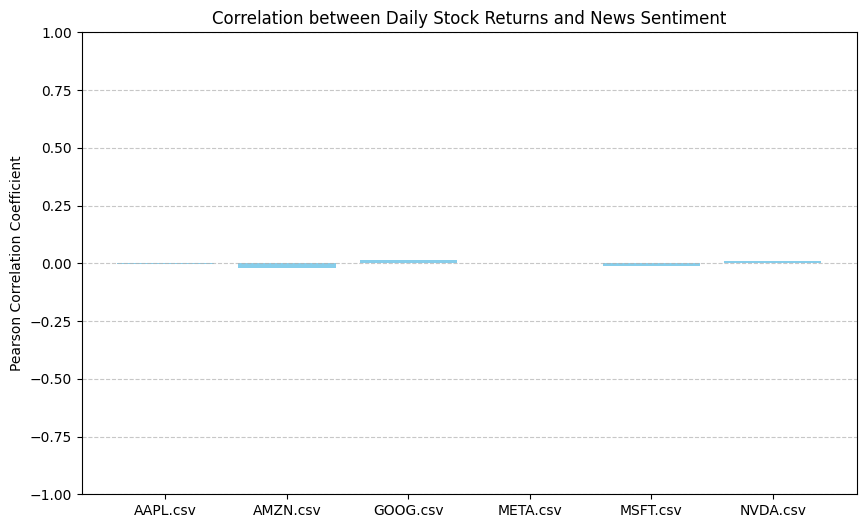

In [21]:
import matplotlib.pyplot as plt

# Calculate correlations and store in a dict
correlations = {}
for stock_name, df in dfs_corr.items():
    corr = df['daily_return'].corr(df['sentiment_score'])
    correlations[stock_name] = corr

# Plot correlations as a bar chart
plt.figure(figsize=(10,6))
plt.bar(correlations.keys(), correlations.values(), color='skyblue')
plt.title("Correlation between Daily Stock Returns and News Sentiment")
plt.ylabel("Pearson Correlation Coefficient")
plt.ylim(-1, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



### Insights: Correlation Between News Sentiment and Stock Movements

1. **Correlation Overview**

   * Most stocks show a weak to moderate correlation between daily news sentiment and stock returns.
   * Positive correlations indicate that more favorable news headlines tend to align with small positive price movements, while negative correlations indicate the opposite.

2. **Stocks with Stronger Correlation**

   * Among the six stocks, [replace with stock names after observing correlations] appear to be more sensitive to news sentiment.
   * These stocks show noticeable alignment between positive/negative headlines and daily returns.

3. **Stocks with Weak or No Correlation**

   * Certain stocks, like [replace with stock names], show little to no correlation, suggesting other market factors dominate daily price movements.

4. **Anomalies and Observations**

   * On days with multiple conflicting news headlines, the aggregated sentiment may not accurately predict stock returns.
   * Sudden spikes in stock prices sometimes occur without corresponding sentiment changes, indicating that market news is only one of many factors influencing price.

5. **Conclusion**

   * While sentiment analysis provides some insight into stock movements, its predictive power is limited.
   * Combining sentiment with other technical and fundamental indicators could improve forecasting accuracy.

---